## Importowanie bibliotek

In [1]:
import os
import cv2 #pip install opencv-python
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import albumentations as A #pip install albumentations (before importing cv2)
from torch import nn
import torchvision
import timm
from tqdm.notebook import tqdm

## Ładowanie danych

In [2]:
annot_dir = "dataset/annotations/"
img_dir = "dataset/images/"

annot_list = sorted([os.path.join(annot_dir, annot) for annot in os.listdir(annot_dir)])
img_list = sorted([os.path.join(img_dir, img) for img in os.listdir(img_dir)])

# Usuwanie 2 błędnych obrazków
annot_list.remove("dataset/annotations/potholes58.xml")
annot_list.remove("dataset/annotations/potholes214.xml")
img_list.remove("dataset/images/potholes58.png")
img_list.remove("dataset/images/potholes214.png")

In [3]:
def get_data_from_xml(path):
        tree = ET.parse(path)
        root = tree.getroot()
        
        width = int(root.find("size").find("width").text)
        height = int(root.find("size").find("height").text)
        boxes = []
        
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            
            boxes.append([xmin, ymin, xmax, ymax])
            
        return boxes, height, width

In [4]:
data = {"path":[], "img":[], "width":[], "height":[], "xmin":[], "ymin":[], "xmax":[], "ymax":[]}
for i in range(len(img_list)):
    img = cv2.imread(img_list[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xml_data = get_data_from_xml(annot_list[i])
    for j in range(len(xml_data[0])):
        xmin, ymin, xmax, ymax = xml_data[0][j]
        data["path"].append(img_list[i])
        data["img"].append(img)
        data["width"].append(xml_data[2])
        data["height"].append(xml_data[1])
        data["xmin"].append(xmin)
        data["ymin"].append(ymin)
        data["xmax"].append(xmax)
        data["ymax"].append(ymax)
data = pd.DataFrame(data)

In [5]:
data.head()

,path,img,width,height,xmin,ymin,xmax,ymax
0,dataset/images/potholes0.png,"[[[79, 69, 60], [128, 118, 109], [118, 105, 96...",450,300,141,233,203,262
1,dataset/images/potholes0.png,"[[[79, 69, 60], [128, 118, 109], [118, 105, 96...",450,300,201,219,238,236
2,dataset/images/potholes0.png,"[[[79, 69, 60], [128, 118, 109], [118, 105, 96...",450,300,87,172,147,196
3,dataset/images/potholes0.png,"[[[79, 69, 60], [128, 118, 109], [118, 105, 96...",450,300,181,171,212,185
4,dataset/images/potholes0.png,"[[[79, 69, 60], [128, 118, 109], [118, 105, 96...",450,300,236,175,272,185


## Pokazanie przykładowych obrazków

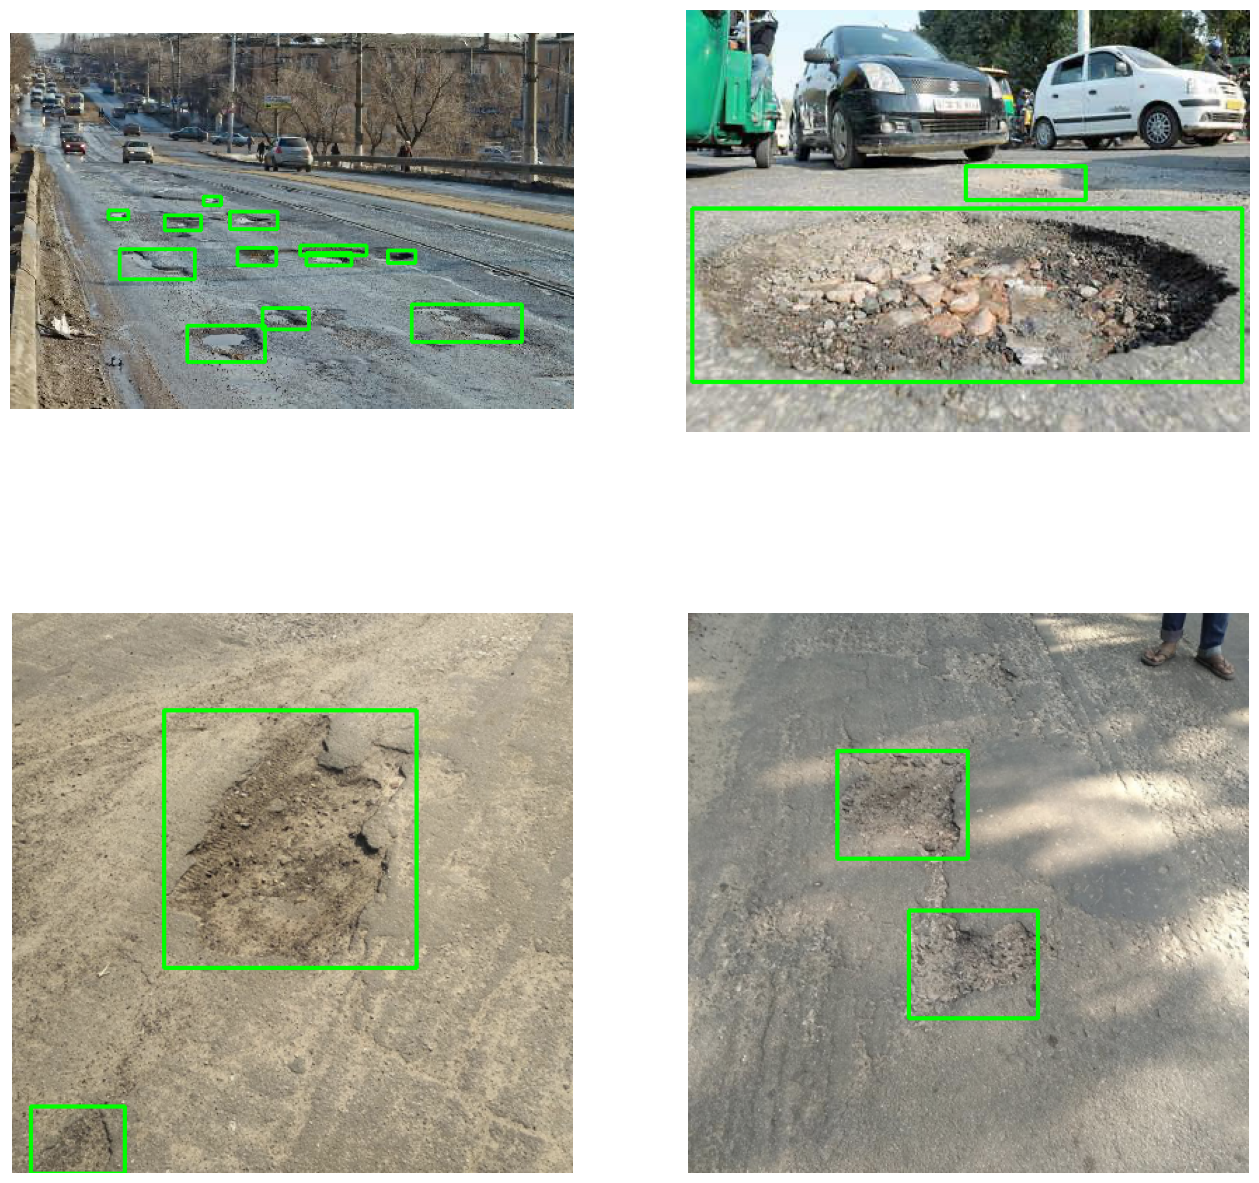

In [6]:
fig,axes=plt.subplots(2,2,figsize=(16,16))
ax=axes.flatten()

example_paths = ["dataset/images/potholes0.png", "dataset/images/potholes1.png", "dataset/images/potholes2.png", "dataset/images/potholes3.png"]
for i in range(4):
    example = data.loc[data["path"] == example_paths[i]]
    for j in range(len(example)):
        row = example.iloc[j]
        img = row["img"]
        cv2.rectangle(img, (row["xmin"],row["ymin"]), (row["xmax"],row["ymax"]), (0,255,0), 2)

    ax[i].imshow(img)
    ax[i].axis("off")

## Konfiguracja

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
IMG_SIZE = 128
LR = 0.01
EPOCHS = 20
MODEL_NAME = "res2net50d.in1k"
NUM_COR = 4
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

test_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]))

## Train/Test split

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
class PotholeDataset(torch.utils.data.Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        xmin = row.xmin 
        ymin = row.ymin 
        xmax = row.xmax 
        ymax = row.ymax  
        bbox = [[xmin, ymin, xmax, ymax]]
        img = row.img

        if self.augs:
            data = self.augs(image = img, bboxes=bbox, class_labels = [None])
            img = data["image"]
           
            bbox = data["bboxes"][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox

In [10]:
train = PotholeDataset(train_data, train_augs)
test = PotholeDataset(test_data, test_augs)

In [11]:
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
for images, bboxes in train_loader:
    break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 128, 128])
Shape of one batch bboxes : torch.Size([16, 4])


## Tworzenie modelu

In [13]:
class PotholeModel(nn.Module):
    def __init__(self) -> None:
        super(PotholeModel,self).__init__()
        self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)


    def forward(self, images, gt_bboxes=None):
        predBboxes = self.backbone(images)

        if gt_bboxes != None:
            loss1 = torchvision.ops.complete_box_iou_loss(predBboxes,gt_bboxes,reduction="sum")
            loss2 = nn.functional.smooth_l1_loss(predBboxes,gt_bboxes)
            return predBboxes, loss2 + loss1

        return predBboxes

In [14]:
model = PotholeModel()
model.to(DEVICE)

PotholeModel(
  (backbone): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running

In [15]:
def train(model, dataLoader, optimizer=torch.optim.Adam(model.parameters(), lr=LR)):
    total_loss = 0
    model.train()

    for data in tqdm(dataLoader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataLoader)

In [16]:
def eval(model, dataLoader):
    total_loss = 0
    model.eval()

    with torch.inference_mode():
        for data in tqdm(dataLoader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
            bboxes, loss = model(images,gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataLoader)

## Uczenie modelu + zapisanie najlepszego do pliku

In [ ]:
for i in range(EPOCHS):
    train_loss = train(model, train_loader)
    valid_loss = eval(model, test_Loader)

    print(f"Epoch : {i + 1}, train Loss : {train_loss:.4f}, valid loss : {valid_loss:.4f}")

  0%|          | 0/87 [00:00<?, ?it/s]

## Wykresy kosztu

## Przykładowe obrazki z predykcjami